# __Classifying Dark Matter Substructure using Convolutional Visual Transformer (CvT)__


This approach uses Haiping Wu et al., <b> Convolutional vision Transformer (CvT) </b>, that combine the desirable properties of convolutional neural networks (CNNs) to the ViT architecture. It keeps CNN properties - shift, scale, and distortion invariance while maintaining the merits of Transformers - dynamic attention, global context, and better generalization. This enables to bring together the best of both designs.

This is accomplished through two primary modifications: a hierarchy of Transformers containing a new convolutional token embedding, and a convolutional Transformer block leveraging a convolutional projection. 

This resulted in a lightweight Vision transformer with around 0.46M parameters and a training time of approx 2 hours on Tesla K80 12 GB (Google Colab) with the given [dataset](https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing). The experiment with CvT opens up the door towards building lighter and faster models for the task in hand. 

## __Results__

| S.No | Metric | Value |
| --- | --- | --- |
| 1. | Best validation accuracy | 86.95% |
| 2. | AUC (with sub structure)  | 0.9532 |
| 3. | AUC (without sub structure)  | 0.9464 |



# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies. The cell also clone the solution repo as it contains a custom file for Convolutional Vision Transformers (CvT). 

In [2]:
# %%bash
# !pip install  gdown \
#               split-folders \
#               torchinfo \
#               einops

# !git clone <assignment-repo-name>

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [ ]:
# %%bash
# bash setup.bash

# __Essential imports__

In [4]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from torchinfo import summary
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

from cvt import CvT

## __Make required folders for data and models__

In [5]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
A set of simulated strong gravitational lensing images with and without substructure. 

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With substructure | 5000 |
| 2. | Without substructure | 5000 |

In [6]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

Downloading...
From: https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr
To: /content/data/lenses.tgz
100%|██████████| 5.46M/5.46M [00:00<00:00, 68.0MB/s]


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
    lenses
    ├── train
    │   ├── no_sub
    │   └── sub
    └── val
        ├── no_sub
        └── sub
```

In [7]:
# initialize the data directory name  
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracting folder


Copying files: 10000 files [00:04, 2232.51 files/s]


In [8]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.0+cu111


## __Set Config and Hyperparameters__

In [9]:
# Data setting
n_classes = 2               # number of classes to be classified
img_size = 224              # image size (224x224)

# Training parameters
batch_size = 64             # batch size
epochs = 40                 # number of epochs
lr = 1e-4                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning
step_size_opt = 5           # interval to apply optimizer scheduler 
use_lr_schedule = False     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used

In [10]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## __Select CUDA device for training__

In [11]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [12]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


#### __Logger to save the results__

In [13]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [14]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## __Set the path for saving trained model name__

In [15]:
PATH = os.path.join("model", f"ConvTransformer_{current_time}.pt")

## __Transformations__ 

Due to limited data, multiple transformation strategies were used and tested. <br>
Winning strategy:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
5. Random Affine in both orientation (20 $^{\circ}$ - 80 $^{\circ}$), translation (0.1 - 0.2) and scaling (0.4-0.95)
6. Random Perspective with distortion scale=0.3 and probability = 0.1
7. Resized to $224 \times 224$.
8. Converting to grayscale
9. Converting PIL image to tensor

Some parts of transformation were also refered from the existing implementation with equivariant networks.

__Tested Strategies__: <br>
Randomly select a predefined combination of transformation from a list e.g. transform1 & transform2 in order to have variation in training data. Also, no alteration in color setting was made as the data is more or less similar with respect to color statistics. 

In [16]:
# images are padded to have shape 129x129.
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts
# upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [17]:
def get_transform_train():

  random_transform = []

  transform1 = transforms.Compose([
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
      RandomPerspective(distortion_scale=0.3, p=0.1),
      ])
  
  transform2 = transforms.Compose([
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
      ])
  
  transform_list = [transform1, transform2]

  transform_prob = 1.0 / len(transform_list)
  for transform in transform_list:
      random_transform.append( transforms.RandomApply([transform], transform_prob) )


  transform_train = Compose([
      transforms.RandomCrop(128),
      pad,
      resize1,
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
      RandomPerspective(distortion_scale=0.3, p=0.1),
      # transforms.RandomApply(random_transform, 0.9999),
      Resize((224, 224)),
      togray,
      totensor,
  ])
  return transform_train

transform_test = Compose([
    transforms.RandomCrop(128),
    pad,
    Resize((224, 224)),
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [18]:
class CustomDataset(Dataset):
    """Create custom dataset for the given data

    """

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [19]:
trainset = CustomDataset(data_dir,'train',transform=get_transform_train())
valset = CustomDataset(data_dir,'val',transform=transform_test)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


## __Dataloader__ 
Loading train and test data with shuffle and given batch size

In [20]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## __Visualize train image samples__

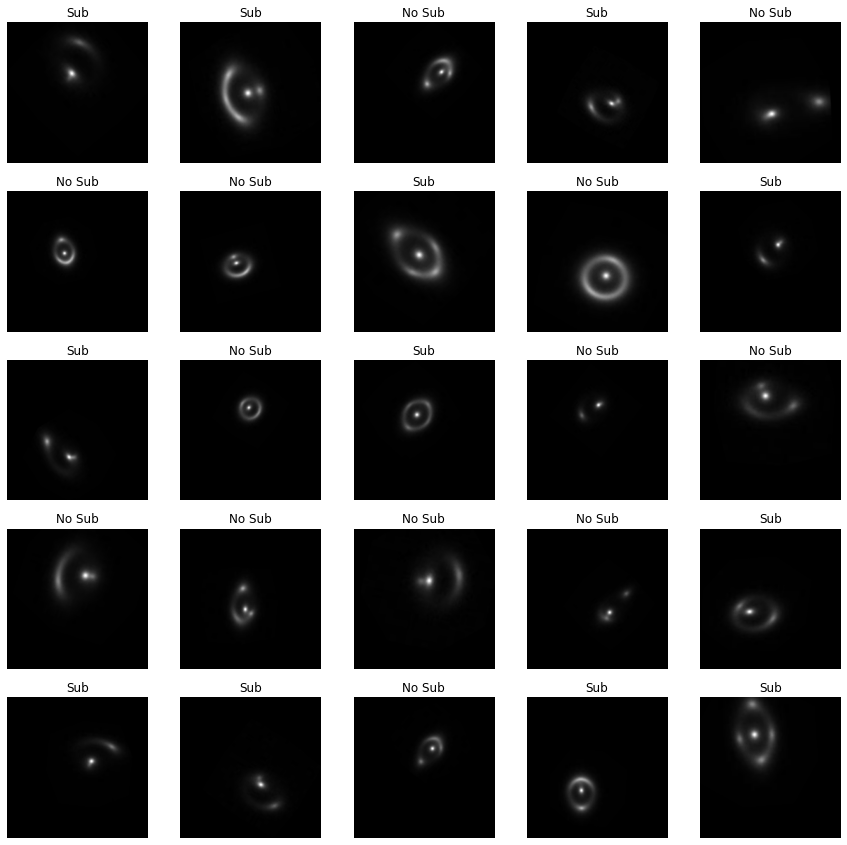

In [21]:
labels_map = {0: 'No Sub',1:'Sub'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    im = img.squeeze()
    plt.imshow(im, cmap='gray')
plt.show()

In [22]:
# get the number of samples in train and test set
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 9000
Val Data: 1000


### **Model Definition (CvT)**
This section graphically shows the architecture of the Convolutional Vision Transformer (CvT) used for binary classification.

![CvT](CvT%20architecture.png)
<!-- file:///home/kartik/git/GSoc2022_test/CvT%20architecture.png -->

<figcaption align = "center"><b>Hierarchical multi-stage structure facilitated by the Convolutional Token Embedding layer*</b></figcaption>

<br>

<p align="center">
  <img src="./Convolutional%20Transformer%20Block.png">
  <figcaption align = "center"><b>Details of the Convolutional Transformer Block*</b></figcaption>
</p>

**source: Haiping Wu et al., Convolutional vision Transformer (CvT)* <br>
**Note: The CvT has been modified to make it more lighweight for the test purpose for compensating limited data*

## __Model Initialization__

In [23]:
# Lightweight CvT
v = CvT(
    channels = 1,           # channels - input channels of image
    num_classes = 2,        # classes - structure type
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel size
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 2,           # stage 1 - heads
    s1_depth = 2,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 128,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 1,
    s2_mlp_mult = 4,
    mlp_last = 128,
    dropout = 0.1
).to(device)

summary(v, input_size=(batch_size, 1, 224, 224))

Layer (type:depth-idx)                                                 Output Shape              Param #
CvT                                                                    --                        --
├─Sequential: 1-1                                                      [64, 2]                   --
│    └─Sequential: 2-1                                                 [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                                                [64, 64, 56, 56]          3,200
│    │    └─LayerNorm: 3-2                                             [64, 64, 56, 56]          128
│    │    └─Transformer: 3-3                                           [64, 64, 56, 56]          135,168
│    └─Sequential: 2-2                                                 [64, 128, 28, 28]         --
│    │    └─Conv2d: 3-4                                                [64, 128, 28, 28]         73,856
│    │    └─LayerNorm: 3-5                                             [64, 128, 2

## __Defining optimizer__

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)

## __Training__

In [25]:
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []
all_test_accuracy = []
all_epoch_loss = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    tr_loss_epoch = []
    running_loss = 0


    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = v(data)
        loss = criterion(output, label)
        epoch_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = epoch_loss / len(train_loader)
    all_epoch_loss.append(epoch_loss)

    correct = 0

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = criterion(val_output, label)
 
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss 
            
        epoch_val_accuracy =epoch_val_accuracy / len(valid_loader)
        epoch_val_loss =epoch_val_loss / len(valid_loader)
        all_val_loss.append(epoch_val_loss)

    
    all_val_accuracy.append(epoch_val_accuracy.item()*100)
    logging.debug(        
        f"Epoch : {epoch+1} - LR {optimizer.param_groups[0]['lr']:.8f} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
    )

    if use_lr_schedule:
        # scheduler_plateau.step(epoch_val_loss)
        scheduler_step.step() 

    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(v)  
        torch.save(best_model.state_dict(), PATH)

  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 1 - LR 0.00010000 - loss : 0.6708 - val_loss : 0.6000 - val_acc: 0.6615 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 2 - LR 0.00010000 - loss : 0.6245 - val_loss : 0.5749 - val_acc: 0.6742 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 3 - LR 0.00010000 - loss : 0.5936 - val_loss : 0.6120 - val_acc: 0.6521 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 4 - LR 0.00010000 - loss : 0.5635 - val_loss : 0.7773 - val_acc: 0.5787 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 5 - LR 0.00010000 - loss : 0.5410 - val_loss : 0.7486 - val_acc: 0.6035 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 6 - LR 0.00010000 - loss : 0.5141 - val_loss : 0.6630 - val_acc: 0.6467 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 7 - LR 0.00010000 - loss : 0.4941 - val_loss : 0.6626 - val_acc: 0.6727 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 8 - LR 0.00010000 - loss : 0.4685 - val_loss : 0.8040 - val_acc: 0.6334 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 9 - LR 0.00010000 - loss : 0.4362 - val_loss : 0.9580 - val_acc: 0.6061 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 10 - LR 0.00010000 - loss : 0.4145 - val_loss : 0.8821 - val_acc: 0.6500 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 11 - LR 0.00010000 - loss : 0.4134 - val_loss : 0.8619 - val_acc: 0.6361 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 12 - LR 0.00010000 - loss : 0.3970 - val_loss : 0.8042 - val_acc: 0.6896 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 13 - LR 0.00010000 - loss : 0.3798 - val_loss : 0.8673 - val_acc: 0.6719 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 14 - LR 0.00010000 - loss : 0.3747 - val_loss : 0.7516 - val_acc: 0.7260 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 15 - LR 0.00010000 - loss : 0.3592 - val_loss : 0.5327 - val_acc: 0.7709 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 16 - LR 0.00010000 - loss : 0.3492 - val_loss : 0.4865 - val_acc: 0.8035 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 17 - LR 0.00010000 - loss : 0.3345 - val_loss : 0.5762 - val_acc: 0.7762 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 18 - LR 0.00010000 - loss : 0.3273 - val_loss : 0.4262 - val_acc: 0.8225 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 19 - LR 0.00010000 - loss : 0.3449 - val_loss : 0.4375 - val_acc: 0.8186 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 20 - LR 0.00010000 - loss : 0.3185 - val_loss : 0.4274 - val_acc: 0.8092 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 21 - LR 0.00010000 - loss : 0.3058 - val_loss : 0.4201 - val_acc: 0.8361 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 22 - LR 0.00010000 - loss : 0.3000 - val_loss : 0.5039 - val_acc: 0.8084 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 23 - LR 0.00010000 - loss : 0.2858 - val_loss : 0.4993 - val_acc: 0.8006 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 24 - LR 0.00010000 - loss : 0.3015 - val_loss : 0.5603 - val_acc: 0.7934 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 25 - LR 0.00010000 - loss : 0.2905 - val_loss : 0.4379 - val_acc: 0.8176 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 26 - LR 0.00010000 - loss : 0.2806 - val_loss : 0.3570 - val_acc: 0.8439 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 27 - LR 0.00010000 - loss : 0.2778 - val_loss : 0.4000 - val_acc: 0.8277 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 28 - LR 0.00010000 - loss : 0.2721 - val_loss : 0.4706 - val_acc: 0.8211 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 29 - LR 0.00010000 - loss : 0.2671 - val_loss : 0.3683 - val_acc: 0.8416 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 30 - LR 0.00010000 - loss : 0.2491 - val_loss : 0.5364 - val_acc: 0.7969 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 31 - LR 0.00010000 - loss : 0.2503 - val_loss : 0.5642 - val_acc: 0.7955 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 32 - LR 0.00010000 - loss : 0.2723 - val_loss : 0.4507 - val_acc: 0.8287 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 33 - LR 0.00010000 - loss : 0.2582 - val_loss : 0.3657 - val_acc: 0.8586 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 34 - LR 0.00010000 - loss : 0.2445 - val_loss : 0.3539 - val_acc: 0.8695 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 35 - LR 0.00010000 - loss : 0.2375 - val_loss : 0.4564 - val_acc: 0.8289 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 36 - LR 0.00010000 - loss : 0.2304 - val_loss : 0.4530 - val_acc: 0.8209 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 37 - LR 0.00010000 - loss : 0.2399 - val_loss : 0.3929 - val_acc: 0.8502 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 38 - LR 0.00010000 - loss : 0.2319 - val_loss : 0.3560 - val_acc: 0.8516 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 39 - LR 0.00010000 - loss : 0.2226 - val_loss : 0.4192 - val_acc: 0.8262 



  0%|          | 0/141 [00:00<?, ?it/s]

DEBUG:root:Epoch : 40 - LR 0.00010000 - loss : 0.2216 - val_loss : 0.4865 - val_acc: 0.8156 



In [26]:
!nvidia-smi

Tue Mar 15 15:37:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0   114W / 149W |  10946MiB / 11441MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## __Evaluation__

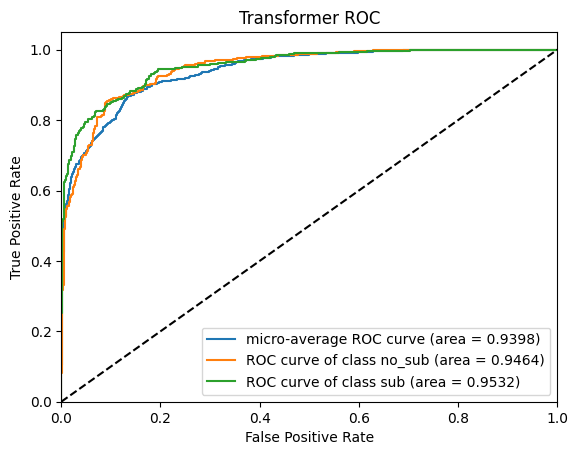

In [30]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(n_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0600a9a450>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f0600a9a450>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


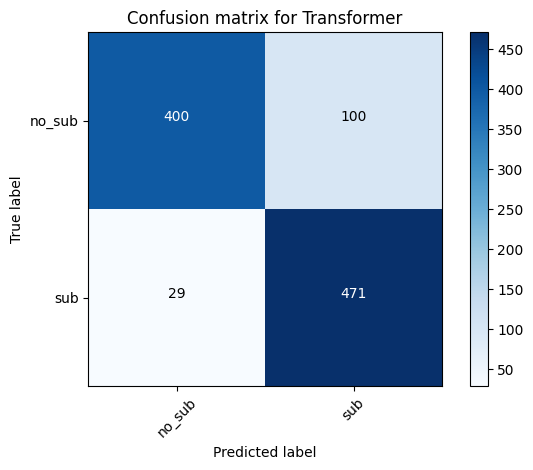

In [32]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1]],title='Confusion matrix for Transformer')

## __Future work__
Experiment above shows that Convolutional Vision Transformer provide lightweight transformer solution which can be effectively trained with a small dataset. However, there are multiple areas of improvement and strategies to be adapted to increase the metrics/results: 
<br>
1. Run hyperparameter tuning using schedulers like Population-based training (PBT) or Hyperband to find better hyperparameters
2. Use extensive data transformation to include more variations in the dataset
3. Explore variations and combinations of networks
4. Lots and lots of data :)

# __Cite__

Inspired from: <br> <br> 
[CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)


  ```
  @article{wu2021cvt,
    title={Cvt: Introducing convolutions to vision transformers},
    author={Wu, Haiping and Xiao, Bin and Codella, Noel and Liu, Mengchen and Dai, Xiyang and Yuan, Lu and Zhang, Lei},
    journal={arXiv preprint arXiv:2103.15808},
    year={2021}
  }
  ```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense

